# Imports

In [1]:
import pandas as pd
from feature_engine.timeseries.forecasting import LagFeatures

from _config import PKL_PROCESSED_STEP1_DTU_SOLAR_STATION, PKL_PROCESSED_STEP2_DTU_SOLAR_STATION

# Load (Preprocessed Step 1) DTU Solar Station data

In [2]:
df = pd.read_pickle(PKL_PROCESSED_STEP1_DTU_SOLAR_STATION)
df = df[sorted(df.columns)]

print(df.shape)
print(df.info())
df.head()

(2460742, 10)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2460742 entries, 2015-03-12 05:36:00 to 2025-01-01 08:04:00
Data columns (total 10 columns):
 #   Column             Dtype  
---  ------             -----  
 0   DHI                float64
 1   DNI                float64
 2   air_pressure       float64
 3   air_temperature    float64
 4   rain_duration      float64
 5   rain_intensity     float64
 6   relative_humidity  float64
 7   solar_altitude     float64
 8   wind_dir_avg       float64
 9   wind_speed_avg     float64
dtypes: float64(10)
memory usage: 206.5 MB
None


,DHI,DNI,air_pressure,air_temperature,rain_duration,rain_intensity,relative_humidity,solar_altitude,wind_dir_avg,wind_speed_avg
2015-03-12 05:36:00,2.890,0.000000,1028.0,0.0,0.0,0.0,81.6,0.004880,85.0,1.0
2015-03-12 05:37:00,3.128,0.000000,1028.0,0.0,0.0,0.0,81.9,0.120481,121.0,0.3
2015-03-12 05:38:00,3.307,0.814740,1028.0,0.0,0.0,0.0,81.7,0.237359,342.0,0.7
2015-03-12 05:39:00,3.657,26.392772,1028.0,0.0,0.0,0.0,81.6,0.355447,342.0,0.7
2015-03-12 05:40:00,4.056,61.929423,1028.0,0.0,0.0,0.0,81.5,0.474681,302.0,1.2


# Lag Features
In order to predict the future values of the target variables, we need to create lagged features. This is done by shifting the values of the features by a certain number of time steps. In this case, we are shifting the values by 60 time steps (1 hour) to predict the future values of the target variables.

In [15]:
TARGETS = ['DNI', 'DHI']
X = df.dropna().drop(columns=TARGETS)  # Drop the target columns and any rows with NaN values because LagFeatures does not handle NaN values.
print(f'Before lagging: {X.shape}')
lf = LagFeatures(periods=[60], drop_original=True, drop_na=True)
# df_lagged = lf.fit_transform(pd.DataFrame(X['air_pressure']))
df_lagged = lf.fit_transform(X)
print(f'After lagging: {df_lagged.shape}')

# Reintroduce the NaN values by reindexing the DataFrame with the full range of timestamps.
# full_range = pd.date_range(start=df_lagged.index.min(), end=df_lagged.index.max(), freq="1min")
# df_lagged = df_lagged.reindex(full_range)
# df_lagged.sort_index(inplace=True)

df_lagged[TARGETS] = df[TARGETS]  # Reintroduce the target columns.
# sort the columns
df_lagged = df_lagged[sorted(df_lagged.columns)]

Before lagging: (2460742, 8)
After lagging: (2460682, 8)


Visualizing that the lagged features are correctly created. \
We see that originally at time t, the df dataframe has the values for the features. \
When looking at the lagged dataframe, we see that the values at time t are now at time t+60 and that the target values are still at time t.

In [16]:
display(df.loc['2022-06-12T11:00:00':'2022-06-12T15:00:00'][:5])
display(df_lagged.loc['2022-06-12T11:00:00':'2022-06-12T15:00:00'][60:65])

,DHI,DNI,air_pressure,air_temperature,rain_duration,rain_intensity,relative_humidity,solar_altitude,wind_dir_avg,wind_speed_avg
2022-06-12 11:00:00,107.40,0.0,1012.0,18.6,10.0,0.0,55.9,57.333589,242.0,3.9
2022-06-12 11:01:00,99.50,0.0,1012.0,18.5,40.0,3.1,55.9,57.343302,238.0,2.9
2022-06-12 11:02:00,94.41,0.0,1012.0,18.5,60.0,3.3,56.7,57.351976,236.0,3.3
2022-06-12 11:03:00,90.15,0.0,1012.0,18.4,60.0,11.1,57.7,57.359607,258.0,4.1
2022-06-12 11:04:00,102.10,0.0,1012.0,18.3,60.0,25.0,58.0,57.366196,241.0,4.7


,DHI,DNI,air_pressure_lag_60,air_temperature_lag_60,rain_duration_lag_60,rain_intensity_lag_60,relative_humidity_lag_60,solar_altitude_lag_60,wind_dir_avg_lag_60,wind_speed_avg_lag_60
2022-06-12 12:00:00,286.2,630.421623,1012.0,18.6,10.0,0.0,55.9,57.333589,242.0,3.9
2022-06-12 12:01:00,270.7,630.823404,1012.0,18.5,40.0,3.1,55.9,57.343302,238.0,2.9
2022-06-12 12:02:00,258.6,698.328352,1012.0,18.5,60.0,3.3,56.7,57.351976,236.0,3.3
2022-06-12 12:03:00,252.3,779.535469,1012.0,18.4,60.0,11.1,57.7,57.359607,258.0,4.1
2022-06-12 12:04:00,244.9,620.329962,1012.0,18.3,60.0,25.0,58.0,57.366196,241.0,4.7


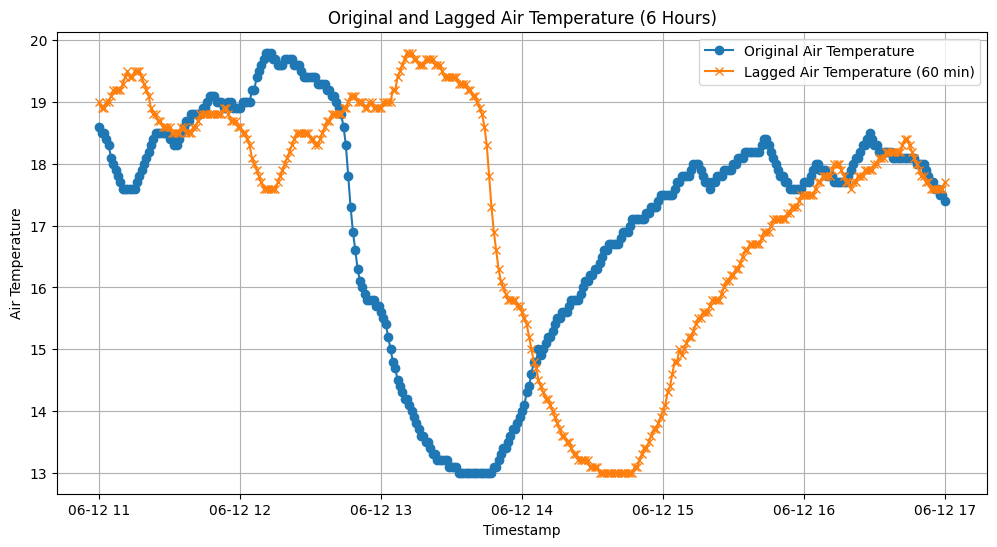

In [17]:
import matplotlib.pyplot as plt

# Select a 6-hour range of data
start_time = '2022-06-12T11:00:00'
end_time = '2022-06-12T17:00:00'

# Extract the original and lagged air temperature
original_air_temp = df.loc[start_time:end_time, 'air_temperature']
lagged_air_temp = df_lagged.loc[start_time:end_time, 'air_temperature_lag_60']

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(original_air_temp, label='Original Air Temperature', marker='o')
plt.plot(lagged_air_temp, label='Lagged Air Temperature (60 min)', marker='x')
plt.title('Original and Lagged Air Temperature (6 Hours)')
plt.xlabel('Timestamp')
plt.ylabel('Air Temperature')
plt.legend()
plt.grid()
plt.show()

In [14]:
df_lagged.to_pickle(PKL_PROCESSED_STEP2_DTU_SOLAR_STATION)

In [10]:
df_lagged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5159609 entries, 2015-03-12 06:36:00 to 2025-01-01 08:04:00
Freq: min
Data columns (total 10 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   DHI                       float64
 1   DNI                       float64
 2   air_pressure_lag_60       float64
 3   air_temperature_lag_60    float64
 4   rain_duration_lag_60      float64
 5   rain_intensity_lag_60     float64
 6   relative_humidity_lag_60  float64
 7   solar_altitude_lag_60     float64
 8   wind_dir_avg_lag_60       float64
 9   wind_speed_avg_lag_60     float64
dtypes: float64(10)
memory usage: 433.0 MB
